In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os, glob

In [2]:
N_IMAGES_TRAIN = 20_000
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 100

In [3]:
# First we define a custom dataset class to be able to create the DataLoader properly

class CustomImageDatasetCOLOR(torch.utils.data.Dataset):
    def __init__(self, labels_file, img_dir, separator=',', img_type="png",transform=None, max_images=None):
        # As labels, we select the 'c' column of the dataset, which contains the number
        # of circles of the image
        aux = pd.read_csv(labels_file,sep=separator)
        aux.drop(columns=aux.columns[0], axis=1,inplace=True)
        aux.drop(columns=aux.columns[1:], axis=1, inplace=True)
        self.img_labels = aux.to_numpy().squeeze()
        if max_images is not None:
            self.img_labels = self.img_labels[:max_images]
        self.img_dir = img_dir
        self.transform = transform
        self.img_type = img_type

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # To get the images, we transform the index to a 5 long string (so 28 -> 00028)
        # and we use that to read the image.
        img_name = str(idx).zfill(5)+'.'+self.img_type
        img_path = os.path.join(self.img_dir, img_name)
        gray = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
        label = self.img_labels[idx,]
        if self.transform:
            image = self.transform(image)
            image = image.float()
        label = torch.tensor(label, dtype=torch.float32)
        return (image, label)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))    
    ])

train_dataset = CustomImageDatasetCOLOR(labels_file='data/train/dades.csv', img_dir='data/train', separator=';', transform=transform)
test_dataset = CustomImageDatasetCOLOR(labels_file='data/val/dades.csv', img_dir='data/val', separator=';', transform=transform)

train_loader = DataLoader(train_dataset, TRAIN_BATCH_SIZE)
test_loader = DataLoader(test_dataset, TEST_BATCH_SIZE)

In [5]:
# Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', weights=True)

# Model description
AlexNet_model.eval()

Using cache found in C:\Users\sanso/.cache\torch\hub\pytorch_vision_v0.6.0
C:\Users\sanso\miniconda3\envs\torchCUDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
for param in AlexNet_model.features.parameters():
    param.requires_grad = False

ModifiedAlexNet = nn.Sequential(AlexNet_model.features, nn.Flatten(1,-1), nn.Linear(2304,256), nn.ReLU(), nn.Linear(256,1))

ModifiedAlexNet.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=2304, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = output.squeeze()
        loss = loss_func(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item() / len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.squeeze()
            test_loss += loss_func(output, target)
            output = torch.round(output)
            correct += output.eq(target.view_as(output)).sum().item()
 
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [8]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 20
lr = 0.01

model = ModifiedAlexNet.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Parameters ", pytorch_total_params)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = torch.nn.MSELoss()

# Guardam el valor de pèrdua promig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_loader)


Parameters  590337
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.228152, Average: 0.017407
Train Epoch: 0 [12800/50000 (26%)]	Loss: 0.237521, Average: 0.001856
Train Epoch: 0 [25600/50000 (51%)]	Loss: 0.228626, Average: 0.001786
Train Epoch: 0 [38400/50000 (77%)]	Loss: 0.233629, Average: 0.001825

Train set: Average loss: 0.0145


Test set: Average loss: 0.0019, Accuracy: 1490/2000 (74%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.144894, Average: 0.001132
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.186386, Average: 0.001456
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.210240, Average: 0.001642
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.212848, Average: 0.001663

Train set: Average loss: 0.0015


Test set: Average loss: 0.0017, Accuracy: 1527/2000 (76%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.135695, Average: 0.001060
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.174511, Average: 0.001363
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.201736, Average: 0.001576
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.214402

In [9]:
torch.save(model, "TransferAlexNet.pth")

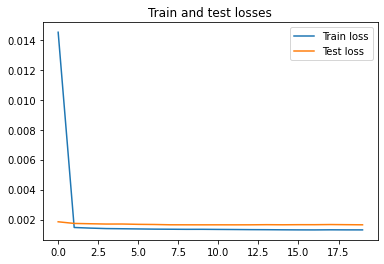

In [24]:
plt.plot(train_l, label="Train loss")
plt.plot(test_l, label="Test loss")
plt.title("Train and test losses")
plt.legend()
plt.show()